This notebook has a neural network learn a harmonic function in pytorch_lightning.

### Load libraries

In [2]:
%load_ext autoreload
%autoreload 2

In [19]:
import dataclasses
import sys

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
sys.path.append("..")

from src.experiments.harmonics.run_experiment import ExperimentConfig
from src.experiments.harmonics.fc_net import FCNet, FCNetConfig
from src.experiments.harmonics.harmonics import (
    HarmonicDataModule,
    HarmonicFn,
    HarmonicFnConfig,
)
import src.utils as utils

### Experiment set up

In [32]:
cfg = ExperimentConfig(
    input_dim=8,
    freq_limit=2,
    learning_rate=3e-4,
    layer_widths=(128, 1024, 1024, 1024, 1),
    batch_size=256,
    early_stopping_monitor="val_mse",
    early_stopping_patience=64,
    max_epochs=100,
)
print(cfg)

hf = HarmonicFn(
    cfg=HarmonicFnConfig(
        input_dim=cfg.input_dim,
        freq_limit=cfg.freq_limit,
        num_components=cfg.num_components,
        seed=-1,
    )
)

pl.seed_everything(42, workers=True)

student = FCNet(
    FCNetConfig(
        input_dim=cfg.input_dim,
        layer_widths=cfg.layer_widths,
        learning_rate=cfg.learning_rate,
    )
)

Global seed set to 42


ExperimentConfig(input_dim=8, freq_limit=2, num_components=8, layer_widths=(128, 1024, 1024, 1024, 1), n_val=10000, val_seed=-2, train_sizes=(1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144), trials_per_size=5, early_stopping=True, early_stopping_patience=64, early_stopping_monitor='val_mse', learning_rate=0.0003, max_epochs=100, batch_size=256, l2_reg=0, num_workers=0)


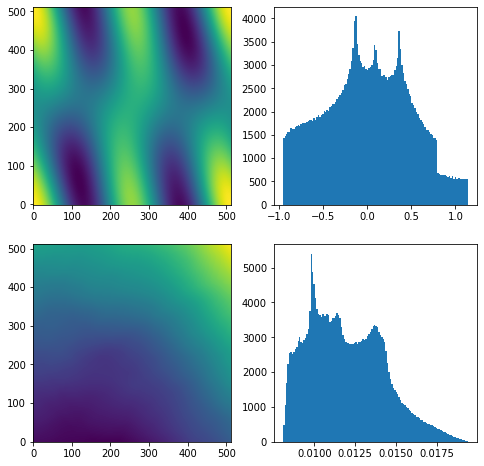

In [33]:
def visualize(
    hf: HarmonicFn,
    student: FCNet,
    pad: tuple[int, int] = (1, 5),
    value: float = 0.5
):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 2, 1)
    img = utils.to_2d_image(
        lambda xs: hf(F.pad(input=xs, pad=pad, mode="constant", value=value)),
        side_samples=512
    ).numpy()
    plt.imshow(img, origin="lower")
    plt.subplot(2, 2, 2)
    plt.hist(img.flatten(), bins=128);

    plt.subplot(2, 2, 3)
    with torch.no_grad():
        img = utils.to_2d_image(
            lambda xs: student(F.pad(input=xs, pad=pad, mode="constant", value=value)),
            side_samples=512
        ).numpy()
    #img = utils.to_2d_image(lambda xs: student.predict(tf.convert_to_tensor(xs.reshape(-1, 2))).reshape(512, 512), side_samples=512)
    plt.imshow(img, origin="lower");
    plt.subplot(2, 2, 4)
    plt.hist(img.flatten(), bins=128);
    
visualize(hf, student)

### Training

In [34]:
dm = HarmonicDataModule(
    hf=hf,
    n_train=20000,
    n_val=cfg.n_val,
    train_seed=42,
    val_seed=cfg.val_seed,
    num_workers=cfg.num_workers,
)

In [35]:
class CustomMLFlowCallback(pl.Callback):
    def __init__(self):
        self.metric_list = []

    def on_train_epoch_end(self, trainer: pl.Trainer, *_, **__):
        self.metric_list.append({k: float(v) for k, v in trainer.logged_metrics.items()})

        
cc = CustomMLFlowCallback()
trainer = pl.Trainer(
    gpus=1,
    deterministic=True,
    enable_checkpointing=False,
    logger=False,  # We do custom logging instead.
    log_every_n_steps=1,
    max_epochs=cfg.max_epochs,
    callbacks=[
        EarlyStopping(
            monitor=cfg.early_stopping_monitor,
            patience=cfg.early_stopping_patience,
            mode="min",
        ),
        cc
    ],
    enable_progress_bar=True,
)
trainer.fit(
    model=student,
    datamodule=dm,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-86836228-07b3-a7f9-366b-3a7c39bf6552]
Set SLURM handle signals.

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 2.2 M 
------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.934     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  66%|██████▋   | 79/119 [00:00<00:00, 209.36it/s, loss=0.512]
Validating: 0it [00:00, ?it/s]
Epoch 1:  66%|██████▋   | 79/119 [00:00<00:00, 210.68it/s, loss=0.497] 
Validating: 0it [00:00, ?it/s]
Epoch 2:  66%|██████▋   | 79/119 [00:00<00:00, 217.79it/s, loss=0.526] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  66%|██████▋   | 79/119 [00:00<00:00, 212.90it/s, loss=0.505] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  66%|██████▋   | 79/119 [00:00<00:00, 212.40it/s, loss=0.498] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  66%|██████▋   | 79/119 [00:00<00:00, 212.37it/s, loss=0.539] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  66%|██████▋   | 79/119 [00:00<00:00, 158.24it/s, loss=0.515] 
Validating: 0it [00:00, ?it/s]
Epoch 7:  66%|██████▋   | 79/119 [00:00<00:00, 216.69it/s, loss=0.501] 
Validating: 0it [00:00, ?it/s]
Epoch 8:  66%|██████▋   | 79/119 [00:00<00:00, 215.54it/s, loss=0.494] 
Validating: 0it [00:00, ?it/s]
Epoch 9:  66%|██████▋   | 79/119 [00:00<00:00, 210.31it/s, loss=0.497] 
Va

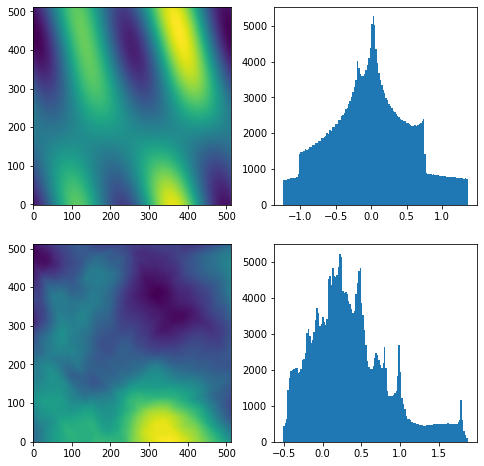

In [36]:
visualize(hf, student, value=0.6)

In [37]:
df = pd.DataFrame(cc.metric_list)
df.head()

,train_mse,val_mse
0,0.802785,0.489263
1,0.575154,0.489743
2,0.750060,0.489721
3,0.337259,0.489300
4,0.617346,0.489864


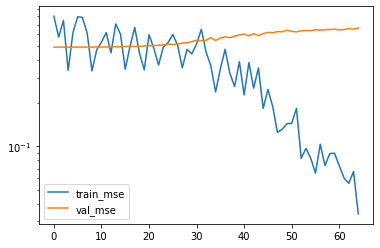

In [38]:
df.plot();
plt.yscale('log')